# Basketball Spatial Analysis and Clustering

In the previous notebook we analyzed the dataset from the distance from the basketball and shot clock perspectives. The analysis was one dimensional in nature. In this notebook we will look at the dataset from a spatial perspective. In order to do that we will make use of the x and y location data in the dataset

In [4]:
#Load dataset and fill in NA values with median


pacman::p_load(dplyr,readr, FactoInvestigate, Factoshiny, DT, corrplot, rio, FactoMineR, tidyr, shiny, lubridate, broom)
 
library(ggfortify)
library(ggplot2)
library(grid)
library(jpeg)
library(cluster) 
library(factoextra)
options(warn=-1)


touch_data <- read_csv("basketball_dataset.csv")
rownames(touch_data) <- touch_data$`...1`

touch_data$`...1` <- NULL

court <- rasterGrob(readJPEG("basketball_court.jpg"),width=unit(1,"npc"), height=unit(1,"npc"))
touch_data$start_shot_clock[is.na(touch_data$start_shot_clock)] <- mean(touch_data$start_shot_clock, na.rm = T)

New names:
• `` -> `...1`
Rows: 1758828 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): chance_id, def_pos, bh_pos
dbl (11): ...1, defender_id, def_height, ballhandler_id, bh_height, start_sh...
lgl  (2): led_to_shot, shot_result

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2-Dimensional Touch Data

How do ball handlers move around the court? We can answer this question by looking at the 2-dimensional court map showing the points where the players move. first let's work on a sample of the data to make processing faster

In [5]:
touch_datas=sample_n(touch_data, 25000)
touch_datas=subset(touch_datas,select = c(touch_start_x,touch_start_y))

Now we create a scatter plot of the x and y coordinates for players and place it on top of the court 

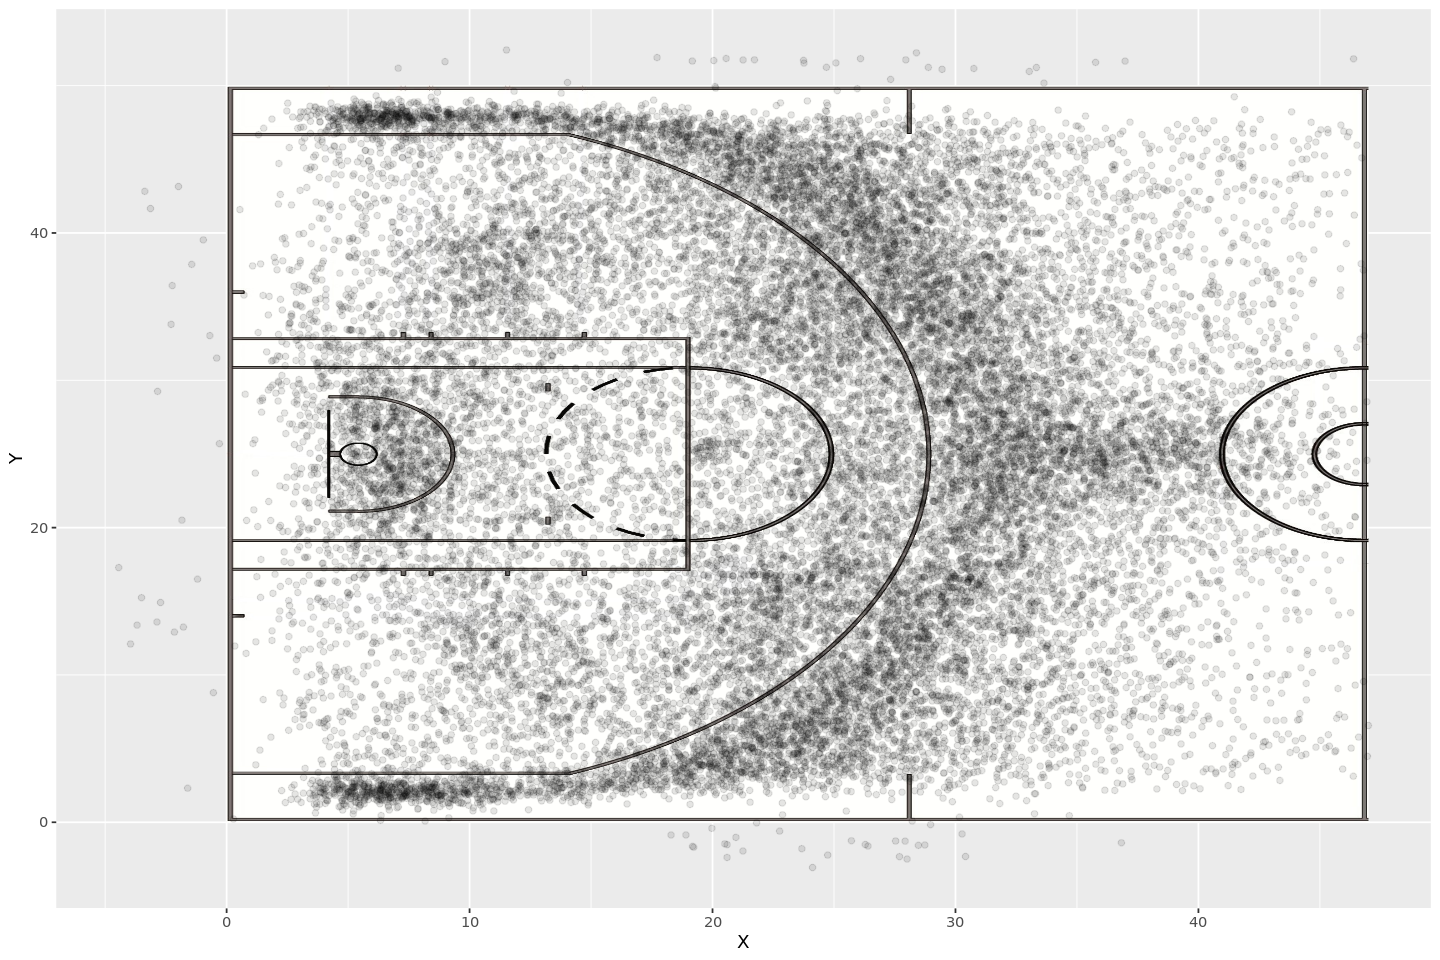

In [6]:

saved <- options(repr.plot.width=12, repr.plot.height=8)

ggplot(touch_datas, aes(touch_start_x, touch_start_y)) +annotation_custom(court, 0, 47, 0, 50) + geom_point(alpha = 0.1 ) + xlab("X") + ylab("Y")

options(saved)


The above plot reveals a lot in terms of player movement. we can see the ball handlers moving arounf the 3-point line a lot. They also move inside the paint. We can see some densities due to the darker regions in the plot. How can we make it more clear? A good way is to use a kernel density function. A 2-D gaussian kernel is a good choice

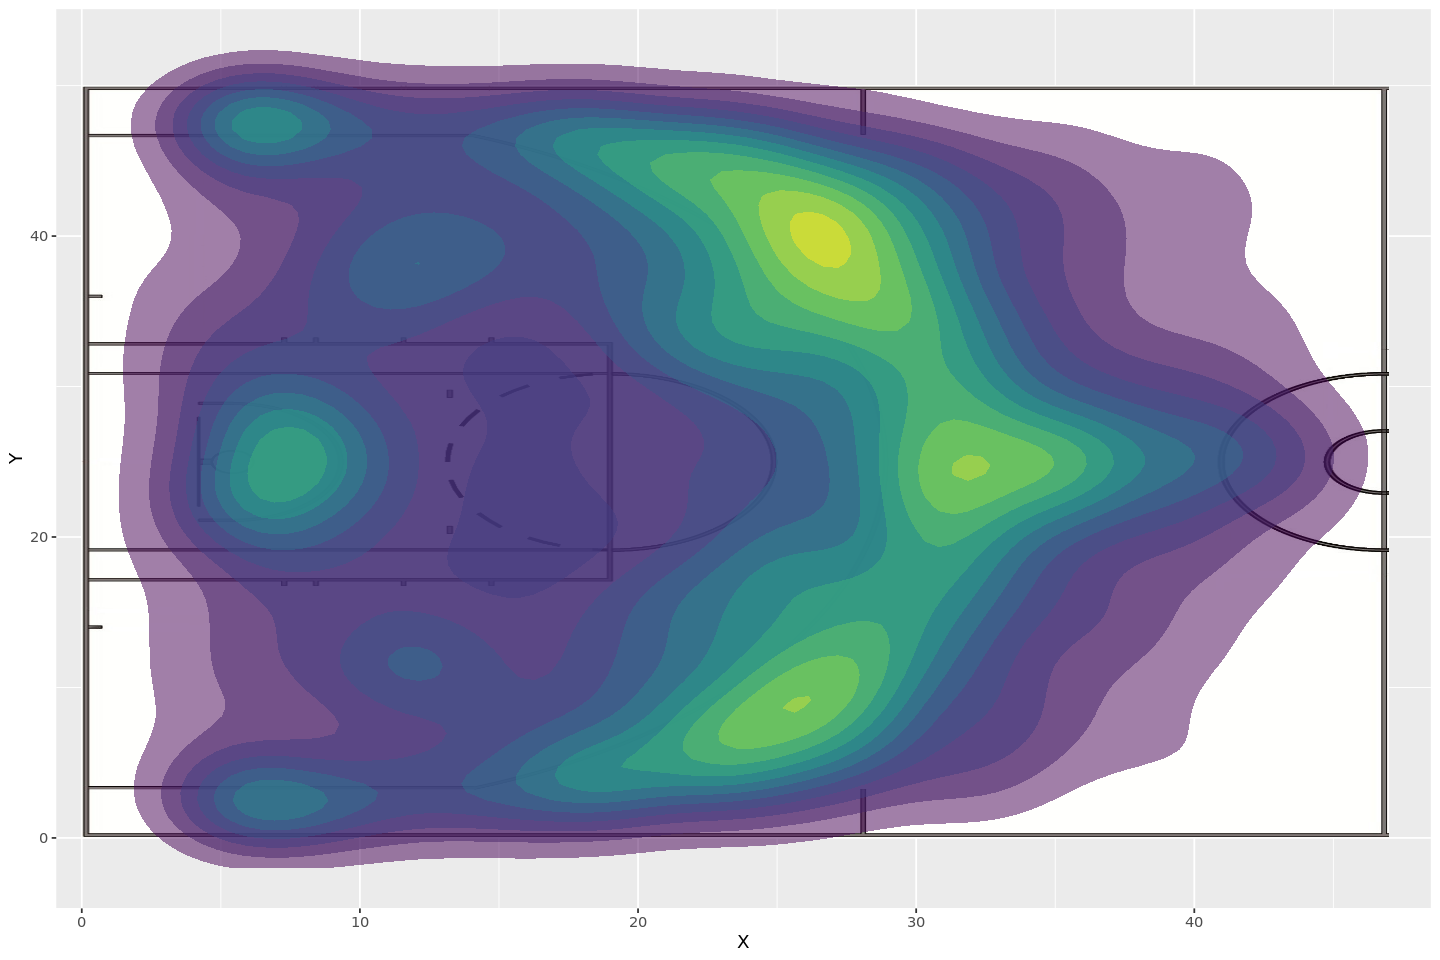

In [8]:
touch_datas=sample_n(touch_data, 12000)
touch_datas=subset(touch_datas,select = c(touch_start_x,touch_start_y))


saved <- options(repr.plot.width=12, repr.plot.height=8)

ggplot(touch_datas, aes(touch_start_x, touch_start_y)) +annotation_custom(court, 0, 47, 0, 50) + xlab("X") + ylab("Y") +
  stat_density2d(aes(fill = ..level..), alpha = .5,
                 
                 geom = "polygon", data = touch_datas) + 
  scale_fill_viridis_c() + 
  theme(legend.position = 'none')
 
options(saved)

The picture is more clear now. The highest densities are seen outside the 3-point line (as the yellow color shows), followed by near the sidelines outside the 3-point line. Some hihg densities are seen in the paint as well but to a lesser extent.
This makes sense as most of the time the ball handler is outside the paint trying to make a play inside the paint. As soon as they make inside they attempt a shot right away as that's where the higher shots made percentage is higher

The above shows some regions of high denisty as clarfied. Are there any clusters that the ball handlers make by their movement?
Let's try to do clustering to see if there are natural spatial groupings created by palyers' movement. K-means is a good option to try with. first we need to normalise the data to put the x and y dimensions in a similar scale

In [9]:

min_max_norm <- function(x) {
    (x - min(x)) / (max(x) - min(x))
  }

touch_datas=subset(touch_data,select = c(touch_start_x,touch_start_y))

sample_norm <- as.data.frame(lapply(touch_datas, min_max_norm))

Next we run the k-means and select the number of clusters using the silhouette score

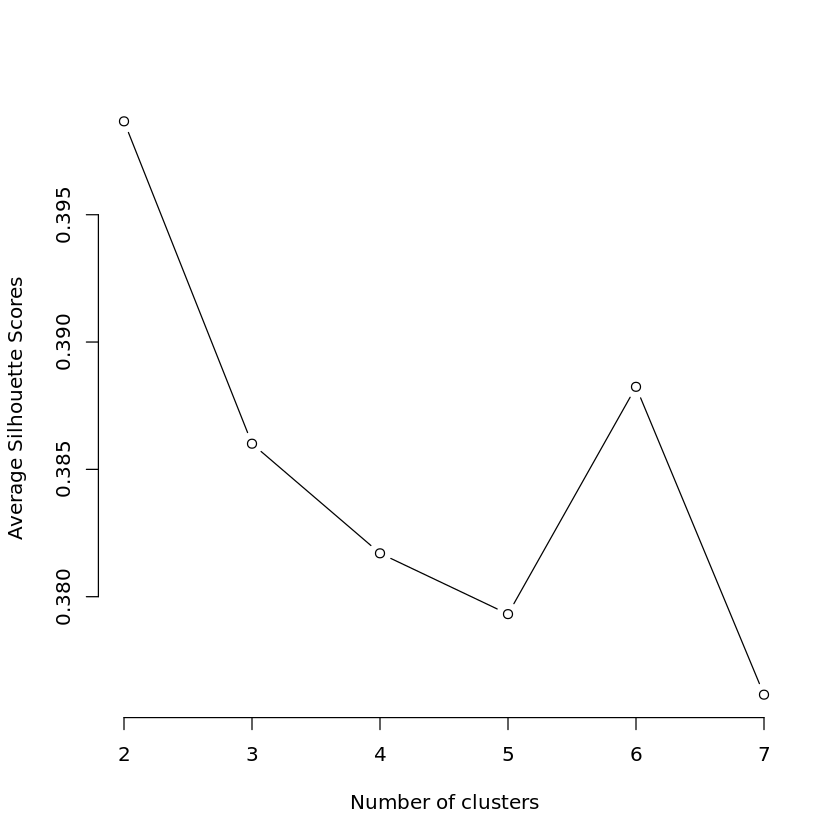

In [10]:
sample_norms=sample_n(sample_norm, 12000)

silhouette_score <- function(k){
  km <- kmeans(sample_norms, centers = k, nstart=25)
  ss <- silhouette(km$cluster, dist(sample_norms))
  mean(ss[, 3])
}
k <- 2:7
avg_sil <- sapply(k, silhouette_score)
plot(k, type='b', avg_sil, xlab='Number of clusters', ylab='Average Silhouette Scores', frame=FALSE)

The maximum silhouette score is seen at 6 clusters. Let's run kmeans with 6 clusters and visualize the results

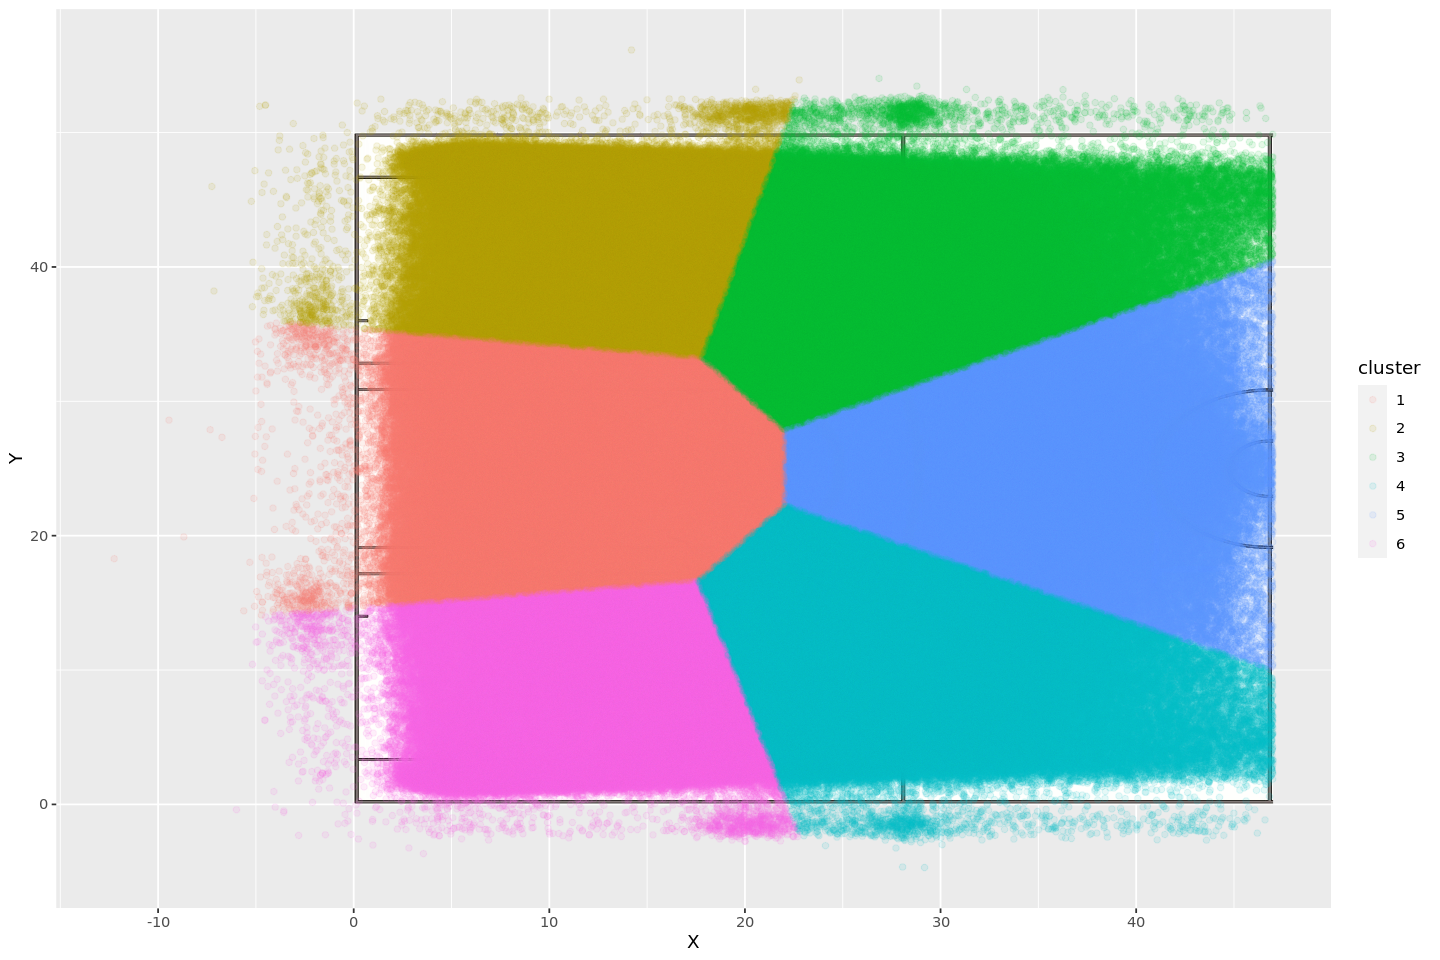

In [12]:
km=kmeans(sample_norm, 6)

touch_datas$cluster=as.factor(km$cluster)

saved <- options(repr.plot.width=12, repr.plot.height=8)
ggplot(touch_datas, aes(touch_start_x, touch_start_y, color = cluster)) +annotation_custom(court, 0, 47, 0, 50) + geom_point(alpha = 0.1 ) + xlab("X") + ylab("Y")

options(saved)

Very nice! K-means clustering was able to group ball touches into regions that align well with the court's layout.
We see a cluster for the paint area along with 5 clusters that encircle the paint in the perimeter.
These clustering results are good to further analyze the movement from one cluster to another by players in case we need to define "offensive plays" and "deffensive plays"

Let's do the cluster analysis one step further. Since we know that the 3-point line actually separates the court into two distinct areas, it would make sense to use it in the cluster analysis. Let's divide the touch data based on the 3-point line (~23.5 ft) then repeat the k-means clustering for each area separately. We can combine them after that then ceck the results

In [14]:

court_2pt=touch_data[touch_data$basket_distance<23.5,]
court_2ptf=subset(court_2pt,select = c(touch_start_x,touch_start_y))

court_3pt=touch_data[touch_data$basket_distance>=23.5,]
court_3ptf=subset(court_3pt,select = c(touch_start_x,touch_start_y))


norm2pt <- as.data.frame(lapply(subset(court_2pt,select = c(touch_start_x,touch_start_y)), min_max_norm))
norm3pt <- as.data.frame(lapply(subset(court_3pt,select = c(touch_start_x,touch_start_y)), min_max_norm))


km2pt=kmeans(norm2pt, 5)
km3pt=kmeans(norm3pt, 4)


court_2pt$cluster=km2pt$cluster
court_3pt$cluster=km3pt$cluster+5


combined=rbind(court_2pt,court_3pt)

combined$cluster=as.factor(combined$cluster)


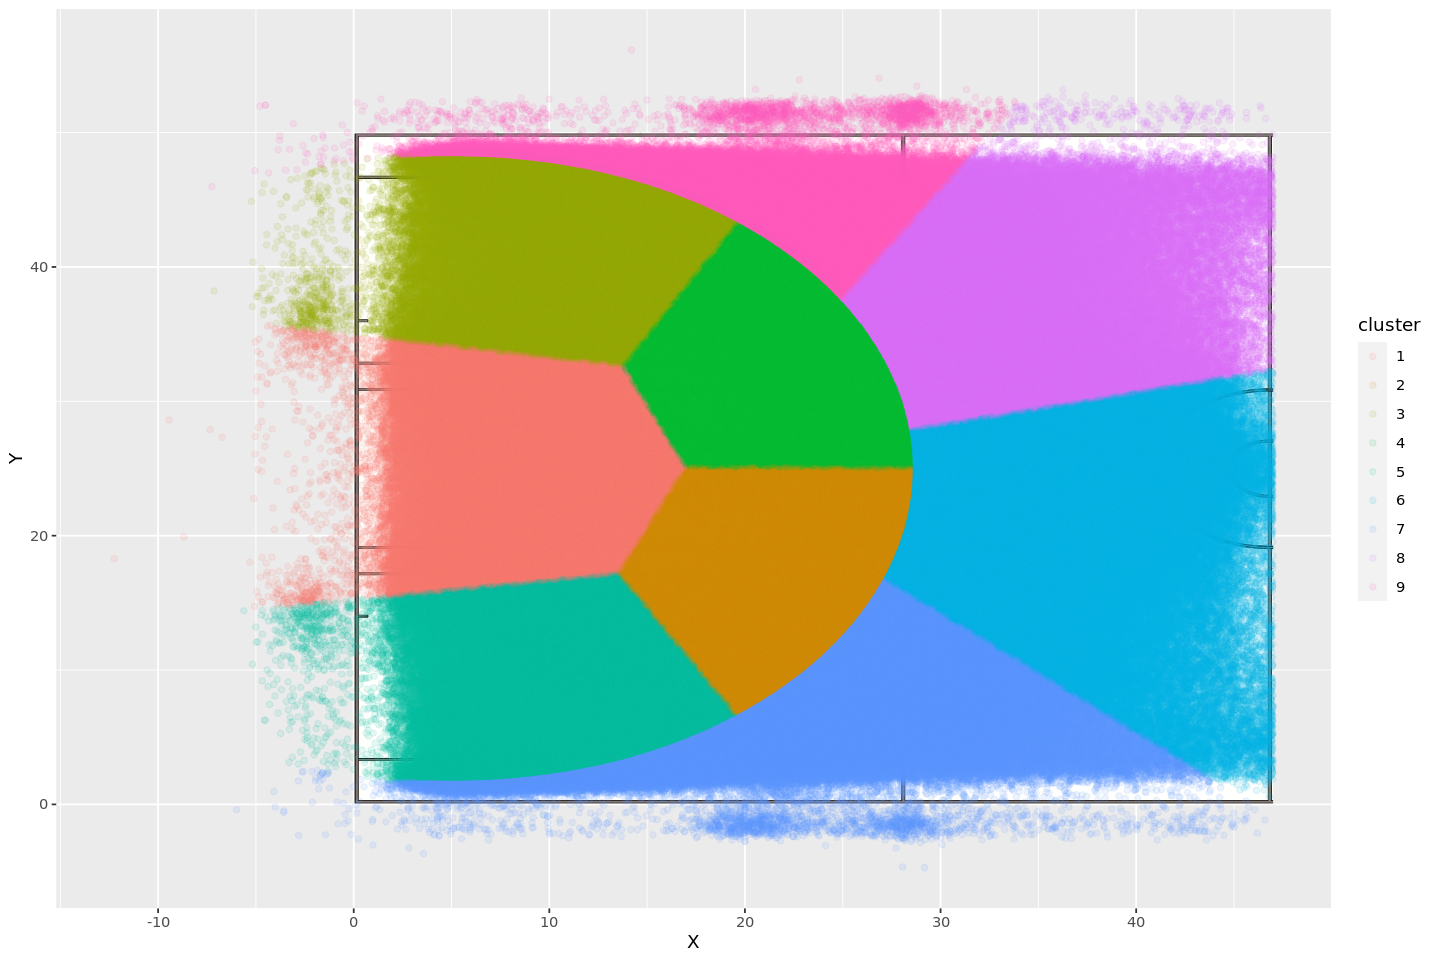

In [15]:
saved <- options(repr.plot.width=12, repr.plot.height=8)

ggplot(combined, aes(touch_start_x, touch_start_y, color = cluster)) +annotation_custom(court, 0, 47, 0, 50) + geom_point(alpha = 0.1 ) + xlab("X") + ylab("Y")

options(saved)

The results are even better! Now we have clusters similar to before where the paint has one clear cluster, and the perimeter is divided into four equally sized clusters encircling the paint. we also have four distinct clusters around the 3-point line.
These cluster have a more clear meaning and they resemble actual areas within the basketball court.



For purposes of defensive player modeling let's run the clustering for the touch_end data as that's what matters when it comes to attempting a shot. Let's use 18 clusters for better granularity

In [16]:
normfull = as.data.frame(lapply(subset(touch_data,select = c(touch_end_x,touch_end_y)), min_max_norm))


km=kmeans(normfull,18)
touch_data$cluster=km$cluster
touch_data$cluster=as.factor(touch_data$cluster)


save clusters for data engineering part

In [5]:
# Save an object to a file
saveRDS(touch_data, file = "my_data_with_18_clusters.rds")
# Restore the object
#touch_data=readRDS(file = "my_data_with_18_clusters.rds")

### Apendix

another option is to divide the court into equally sized grids (10ft x 10ft) and use them as spatial clusters. Below is the code to do that

In [ ]:
for (row in 1:nrow(touch_data)){
  
 if (touch_data$touch_end_x[row] < 0){
   
   zonex=0
 }

 else if (touch_data$touch_end_x[row] > 0 & touch_data$touch_end_x[row] <10){
  
  zonex=1
}else if (touch_data$touch_end_x[row] > 10 & touch_data$touch_end_x[row] <20) {
  
  zonex=2
}else if (touch_data$touch_end_x[row] > 20 & touch_data$touch_end_x[row] <30){
  
  zonex=3
}else if (touch_data$touch_end_x[row] > 30 & touch_data$touch_end_x[row] <40){
  
  zonex=4
}else if (touch_data$touch_end_x[row] > 40 & touch_data$touch_end_x[row] <50) {
  
  zonex=5
}
  
if (touch_data$touch_end_y[row] < 0){
  
  zoney=0
}else if (touch_data$touch_end_y[row] > 0 & touch_data$touch_end_y[row] <10){
  
  zoney=1
}else if (touch_data$touch_end_y[row] > 10 & touch_data$touch_end_y[row] <20){
  
  zoney=2
}else if (touch_data$touch_end_y[row] > 20 & touch_data$touch_end_y[row] <30){
  
  zoney=3
}else if (touch_data$touch_end_y[row] > 30 & touch_data$touch_end_y[row] <40){
  
  zoney=4
}else if (touch_data$touch_end_y[row] > 40 & touch_data$touch_end_y[row] <50){
  
  zoney=5
}else if (touch_data$touch_end_y[row] > 50 & touch_data$touch_end_y[row] <60){
  
  zoney=6
}
    

zone=10*zonex+zoney

touch_data$section[row]=zone
  
}

In [10]:
summary(touch_data)

  chance_id          defender_id       def_pos            def_height   
 Length:1758828     Min.   :  2989   Length:1758828     Min.   :69.00  
 Class :character   1st Qu.:278110   Class :character   1st Qu.:76.00  
 Mode  :character   Median :456456   Mode  :character   Median :80.00  
                    Mean   :428990                      Mean   :79.12  
                    3rd Qu.:553158                      3rd Qu.:82.00  
                    Max.   :922594                      Max.   :89.00  
                                                                       
 ballhandler_id      bh_pos            bh_height     start_shot_clock
 Min.   :  2989   Length:1758828     Min.   :69.00   Min.   : 0.00   
 1st Qu.:266554   Class :character   1st Qu.:76.00   1st Qu.:12.14   
 Median :456451   Mode  :character   Median :80.00   Median :15.04   
 Mean   :423066                      Mean   :79.12   Mean   :15.04   
 3rd Qu.:552805                      3rd Qu.:82.00   3rd Qu.:18.20   
 Max

Let's save the cluster results for later use on our modeling

In [5]:
combined_arranged <- combined %>% arrange(chance_id,start_shot_clock)

In [3]:
# Save an object to a file
#saveRDS(touch_data, file = "my_data_with_clusters.rds")
# Restore the object
touch_data=readRDS(file = "my_data_with_clusters.rds")

In [6]:
(unique(touch_data$section))

[1] 34 14 42 23 13 11 44 24 35 52 22 21 41 43 33 25 31 32 12 15 45 53  3  5 36
[26] 54 30 20  2 55 26 51  4 50 40  1 16 46 10  0 56  6